## Upload the .rbf

Upload the .rbf file of ORNN accelerator using the provided `make` file. Make sure that all the 8 leds go high indicating that the accelerator rbf is uploaded.

In [1]:
!make install

cp DE10_NANO.rbf /lib/firmware/
dtbocfg.rb --install soc_system --dts soc_system.dts


## Necessary Imports

In [2]:
import time
import numpy as np
from pycy import *
from PIL import Image

## Loading the MNIST dataset

MNIST dataset used here is the same which was used for the csim of the accelerator. We will load the same dataset into numpy arrays

In [3]:
def load_mnist_images():
   with open("../Hardware/HLS/utils/mnist_data/t10k-images.idx3-ubyte","rb") as imgs:
      data = np.frombuffer(imgs.read(), np.uint8)

   header, data = data[:16], data[16:]
   data = data.reshape(-1, 28, 28)/255.
   data = 2*data-1
   data = np.pad(data, ((0,0),(2,2),(2,2)), constant_values=(-1, -1))
   return data


def load_mnist_labels():
   labels = []
   with open("../Hardware/HLS/utils/mnist_data/t10k-labels.idx1-ubyte","rb") as lbl_file:
       #read magic number and number of labels (MSB first) -> MNIST header
       magicNum = int.from_bytes(lbl_file.read(4), byteorder="big")
       countLbl = int.from_bytes(lbl_file.read(4), byteorder="big")
       #now the labels are following byte-wise
       for idx in range(countLbl):
           labels.append(int.from_bytes(lbl_file.read(1), byteorder="big"))
       lbl_file.close()
   return labels

In [4]:
mnist_images = load_mnist_images()
mnist_labels = load_mnist_labels()
print(mnist_images.shape, len(mnist_labels))

(10000, 32, 32) 10000


## Quantizing the Input

Next we will define a function for quantizing the input image in signed 4-bits i.e., Q1.3 format and packing it to 64-bits. We will discuss it later in the section in defining io buffers.

In [5]:
def preprocess_image(input_image):
   input_image = np.clip(input_image, -1, 1-2**-3)
   input_image = np.round(input_image*2**3)
   input_image = input_image.reshape(-1)
   q_img = np.zeros(shape=(512,), dtype=np.uint8)
   index = 0
   for i in range(0, len(input_image), 2):
      elem1 = int(input_image[i]) & 0xf
      elem2 = int(input_image[i+1]) & 0xf
      val = (elem2 << 4) | (elem1)
      q_img[index] = val
      index+=1
   q_img = q_img.view(np.uint64)
   return q_img

## Register Address of the Accelerator

Here we will define the necessary register addresses for controlling the ORNN accelerator. These addresses are taken directly from the files `hps_0.h` and `ACCL_TOP_csr.h`.

In [6]:
accl_offset = 0xff200000
start_reg = 0x8
interrupt_enable_reg = 0x10
interrupt_status_reg = 0x18
input_buffer_reg = 0x20
output_buffer_reg = 0x28
seq_len_reg = 0x30

## Defining IO buffer

We will not define contigious memory buffers for reading and writing from the accelerator. These buffers will hold the input which is to be passed to the accelerator, and the output scores given by the acclerator. Moreover these buffers will be 64-bit buffers as the width of the avalon bridge is 64-bits. THe `cma_buffer` class is defined in the `pycy.py` file.

In [7]:
SEQ_LEN = 32
INPUT_BW = 4
OUTPUT_BW = 16
ELEMENTS_IN = 32*SEQ_LEN*INPUT_BW//64 
ELEMENTS_OUT = 16*SEQ_LEN*OUTPUT_BW//64
array_a = cma_buffer(ELEMENTS_IN, np.uint64)
array_b = cma_buffer(ELEMENTS_OUT, np.uint64)

## Instantiating the driver

Now we will used the class `Device_Driver` defined in the `pycy.py` file to create a python driver which allows us to interact with the accelerator with ease. This driver will be used to control the acclerator, pass the io buffers and setting the different input arguments. 

Moreover we will also pass the address of the cma buffers for input output to the accelerator.

In [8]:
ACCL_TOP_csr = Device_Driver(accl_offset, 64)
ACCL_TOP_csr.write(input_buffer_reg,  array_a.physical_address)
ACCL_TOP_csr.write(output_buffer_reg, array_b.physical_address)
ACCL_TOP_csr.write(seq_len_reg, SEQ_LEN)
ACCL_TOP_csr.write(interrupt_enable_reg, 0)
ACCL_TOP_csr.write(interrupt_status_reg, 0x00)


# Single Image Test

Now we are ready to pass the input and run the test on a single image. First lets take the first image of the dataset and visualize it.

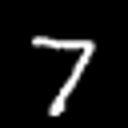

In [9]:
image = mnist_images[0]
image = (image+1)/2
image *= 255
image = image.astype(np.uint8)
im = Image.fromarray(image, 'L')
im = im.resize((128, 128))
im.show()

Now lets see how the image looks like after quantizing it to 4-bits (Not much difference).

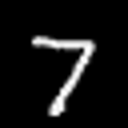

In [10]:
image = mnist_images[0]
image = np.clip(image, -1, 1-2**-3)
image = np.round(image*2**3)/2**3
image = (image+1)/2
image *= 255
image = image.astype(np.uint8)
im = Image.fromarray(image, 'L')
im = im.resize((128, 128))
im.show()

Now we will pass this image to the preprocessing function and put it into the input buffer of the accelerator.

In [11]:
image_no = 0
image = mnist_images[image_no]
label = mnist_labels[image_no]
q_img = preprocess_image(image)
array_a.write(q_img)

## Start the accelerator

Lets now start the accelerator by writing 1 to the start register and wait until its complete.

In [12]:
ACCL_TOP_csr.write(start_reg, 1)
start_time = time.time()
while(not (ACCL_TOP_csr.read(interrupt_status_reg) & 0x2)):
    pass

Let look at the predicted value now which is written to the output buffer by the accelerator. Rememeber that the output type of the accelerator is values is 16-bits i.e., Q6.10 format.

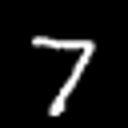

Prediction = 7



In [13]:
pred = array_b.read().view(np.int16)
pred = pred/2**10
max_val = 0
for i in range(SEQ_LEN):
    max_val = 0
    max_score = pred[i*16]
    for j in range(16):
        if j<10:
            if pred[i*16+j] >= max_score:
                max_score = pred[i*16+j]
                max_val = j

image = (image+1)/2
image *= 255
image = image.astype(np.uint8)
im = Image.fromarray(image, 'L')
im = im.resize((128, 128))
im.show()
print("Prediction = {}\n".format(label, max_val))

# Whole dataset Test and FPS

In [14]:
correct = 0
time_tot = 0
for k in range(10000):
    img = mnist_images[k]
    lab = mnist_labels[k]
    q_img = preprocess_image(img)
    array_a.write(q_img)
    ACCL_TOP_csr.write(start_reg, 1)
    start_time = time.time()
    while(not (ACCL_TOP_csr.read(0x18) & 0x2)):
        pass
    time_end = time.time()-start_time
    pred = array_b.read().view(np.int16)
    pred = pred/2**10
    for i in range(SEQ_LEN):
        max_val = 0
        max_score = pred[i*16]
        for j in range(16):
            if j<10:
                if pred[i*16+j] >= max_score:
                    max_score = pred[i*16+j]
                    max_val = j
    if lab == max_val:
        correct += 1
    time_tot += time_end
    print("Accuracy on [{}/10000] images = {:.2f}%".format(k+1, (correct/10000)*100), end='\r')
print("\nImages per second (FPS) = {:.2f}".format(10000/time_tot))


Accuracy on [10000/10000] images = 90.71%
Images per second (FPS) = 1454.72


## Free the Accelerator

In [15]:
!make uninstall

dtbocfg.rb --remove soc_system
rm -f /lib/firmware/DE10_NANO.rbf
